In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pincirollis_data_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/pincirolli_results.csv'
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

# results_base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_10/1000m_1rep_25trials/run_1/'
# results_base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_11/750m_1rep_25trials/run_1/'
results_base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_11/1250m_1rep_25trials/run_1/'
# results_base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_12/500m_1rep_25trials/run_1/'


In [87]:
# Generates data from the step data

cols = ["s3_intensity", "avg_latency_ms"]
df = pd.DataFrame(columns=cols)

max_steps = 25
for step in range(max_steps + 1):
    path = f"{results_base_path}/{step}_steps/mubench_results.csv"
    exp_df = pd.read_csv(path, header=0)
    avg_latency = np.average(exp_df["latency_ms"])
    s3_intensity = step / max_steps
    df.at[step, "s3_intensity"] = s3_intensity
    df.at[step, "avg_latency_ms"] = avg_latency

In [88]:
pinc_df = synth_df[['N_A', 'R0']]
pinc_df.loc[:, 's3_intensity'] = pinc_df['N_A'].transform(lambda x: x / 25)
pinc_df = pinc_df.drop('N_A', axis=1)

df = pd.merge(df, pinc_df, on='s3_intensity')

df

/tmp/ipykernel_2811/2178613000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, 's3_intensity'] = pinc_df['N_A'].transform(lambda x: x / 25)


,s3_intensity,avg_latency_ms,R0
0,0.0,2191.367267,449.008131
1,0.04,2189.113267,430.812565
2,0.08,1004.5314,414.238789
3,0.12,1107.9756,401.059061
4,0.16,979.559667,387.978857
5,0.2,1053.984,378.294597
6,0.24,1363.548733,368.410305
7,0.28,785.418333,359.982102
8,0.32,1048.7014,351.706090
9,0.36,1380.214,344.959313


# Visualization

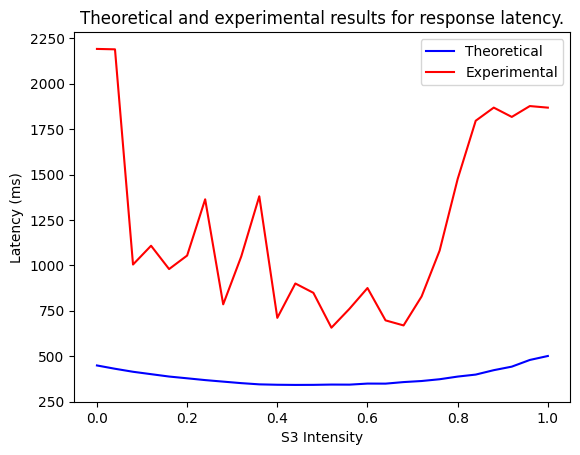

In [89]:
# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.plot(df['s3_intensity'], df["R0"], label='Theoretical', color='blue')

# Plot the second line (cosine function)
ax.plot(df['s3_intensity'], df['avg_latency_ms'], label='Experimental', color='red')

# Add labels and a legend
ax.set_ylabel('Latency (ms)')
ax.set_xlabel('S3 Intensity')
ax.set_title('Theoretical and experimental results for response latency.')
ax.legend()

# Show the plot
plt.show()

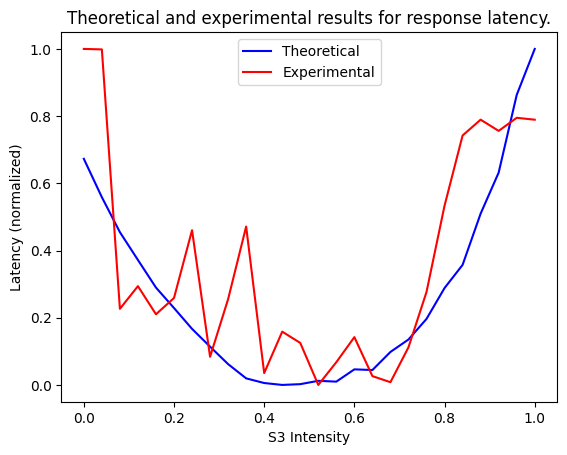

In [90]:
# Visualization of normalized data.


def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = pd.DataFrame()
df_norm["s3_intensity"] = df["s3_intensity"]

r0_min, r0_max = min(df["R0"]), max(df["R0"])
df_norm["R0"] = df["R0"].transform(lambda x: normalize(x, r0_min, r0_max))

lat_min, lat_max = min(df["avg_latency_ms"]), max(df["avg_latency_ms"])
df_norm["avg_latency_ms"] = df["avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.plot(df_norm["s3_intensity"], df_norm["R0"], label="Theoretical", color="blue")

# Plot the second line (cosine function)
ax.plot(
    df_norm["s3_intensity"],
    df_norm["avg_latency_ms"],
    label="Experimental",
    color="red",
)

# Add labels and a legend
ax.set_ylabel("Latency (normalized)")
ax.set_xlabel("S3 Intensity")
ax.set_title("Theoretical and experimental results for response latency.")
ax.legend()

# Show the plot
plt.show()

# Evaluation

## Compares the delay data set using MAPE and Spearman's r

In [91]:
from scipy.stats import spearmanr

correlation_coefficient, p_value = spearmanr(df["R0"], df["avg_latency_ms"])

# Display the result
print(f"Spearman's correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Spearman's correlation coefficient: 0.7935042735042734
P-value: 1.3236240132315497e-06


## Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.  

In [92]:
def mape(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele) / expected_ele)
    m /= len(expected)
    return m

absolute_mape = mape(df['R0'], df['avg_latency_ms'])
eps = 1
normalized_mape = mape(df_norm['R0'] + eps, df_norm['avg_latency_ms'] + eps)

print(f'{absolute_mape=}, {normalized_mape=} ({eps=})')

absolute_mape=0.6469263271467075, normalized_mape=0.1072370585342699 (eps=1)


## Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.

In [93]:
def mae(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele))
    m /= len(expected)
    return m


absolute_mae = mae(df["R0"], df["avg_latency_ms"])
normalized_mae = mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=}, {normalized_mae=}")

absolute_mae=838.8870979569818, normalized_mae=0.15970197746671022
